<a href="https://colab.research.google.com/github/stefanlessmann/ASE-ML/blob/main/Day-4-Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wecome to our Section 14 Deep Learning Practice Session
Today, we revisit the session on explainable AI (XAI) and interpretable machine learning. We start by re-creating the neural network-based credit risk model from the previous session. Neural networks are famous for being black-box models. Thus, our credit risk model is just a perfect example for a non-explainable model that we can diagnose and eventually interpret using the explanation methods discussed in the session.  

The outline of today's session is as follows:
- Create black-box neural network classifier (code already available)
- Explain the black-box using linear regression surrogate model
- Compute permutation-based feature importance
- Examine partial dependence

In [1]:
# Standard libraries for data data handling and plotting
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

Below, we provide the code from the previous practice session, which you can run to load our credit data, train a neural network classifier, and produce test set predictions.


Classification accuracy:  0.8825503355704698


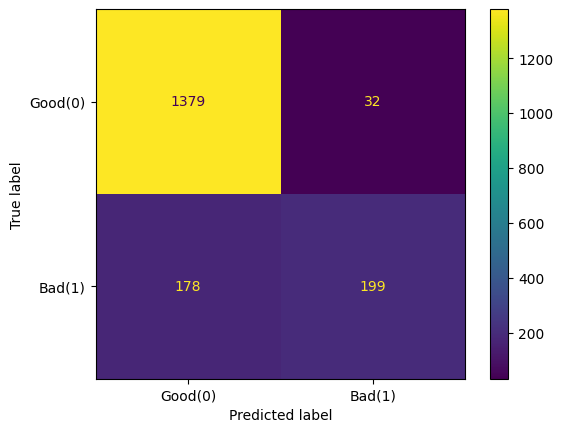

In [2]:
# Load data and create NN-based credit risk model:

# 1. Load data from GitHub
data_url = "https://raw.githubusercontent.com/stefanlessmann/ASE-ML/master/hmeq.csv"
df = pd.read_csv(data_url)

# 2. Perform some minimal preprocessing to facilitate training a NN
df = df.drop(columns=["REASON", "JOB"], axis=1)  # delete categorical features
y = df.pop("BAD")  # Remove the target variable so that it remains unchanged
df = df.fillna(value=df.mean())  # Mean-impute missing values
scaler = MinMaxScaler(feature_range=(0,1))  # Scale feature values
X = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# 3. Partition data into training (70%) and test (30%) sets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)

# 4. Train neural network
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(100, 10), learning_rate_init=0.01, max_iter=1000)
nn.fit(Xtrain, ytrain)

# 5. Compute NN predictions for the test data
yhat = nn.predict(Xtest)

# Compute a performance indicator over the test set predictions. 
from sklearn.metrics import ConfusionMatrixDisplay
print("Classification accuracy: ", nn.score(X=Xtest, y=ytest))
ConfusionMatrixDisplay.from_predictions(y_true=ytest, y_pred=yhat, labels=[0, 1], display_labels=['Good(0)', 'Bad(1)']);


## Surrogate model-based explanation
A surrogate model is, by definition, an intrinsically interpretable model, which we train to predict (aka reproduce) the predictions of a black-box model.

We just created a black-box model above. As surrogate model, we will use linear regression, and see how well we can linearly approximate our NN. Specifically, fit the surrogate model to the predicted class *probabilities* of the neural network using the original features. To predict probabilities, you will need to use the method `predict_proba()`, which any `sklearn` classifier provides.

One question worth discussing in this context is which data set to use for fitting the surroage model, the training or test data. From a programming perspective, it does not make a difference. So first develop your code and then we discuss the subtle differences between the two options.

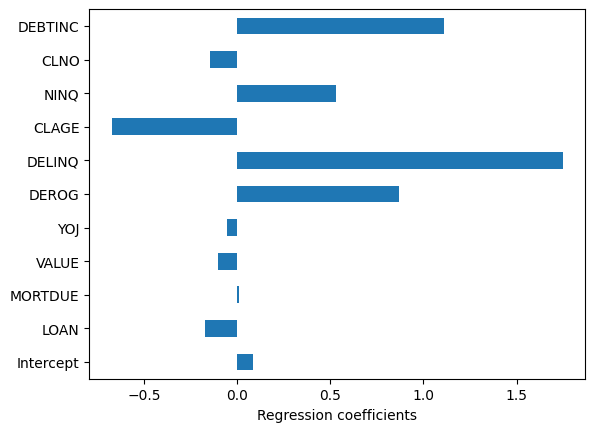

In [3]:
# Linear regression as surrogate model
from sklearn.linear_model import LinearRegression

# Produce (probability) forecasts for the test data
yhat_prob = nn.predict_proba(Xtest)[:,1]

# Fit regress original features on the probability forecast
lreg = LinearRegression()
lreg.fit(Xtest, yhat_prob)
explanation = pd.concat([
    pd.DataFrame([lreg.intercept_], index=["Intercept"]),
    pd.DataFrame(lreg.coef_, index=Xtest.columns)
])
explanation.plot.barh(legend=False)
plt.xlabel("Regression coefficients")
plt.show()





Given that the linear regression can give no more than an approximation of the neural network, it is crucial to examine the quality of the approximation. If it is poor, the insights, which we expect the surrogate model to provide may not be reliable. 

Write some code to assess the quality of the approximation.

In [4]:
# Compare NN predictions to linear regression approximation
test_point = Xtest.iloc[0:1]  # some test point

print("NN probability forecast: ", nn.predict_proba(test_point)[:,1])
print("LR approximation: ", lreg.predict(test_point))

NN probability forecast:  [0.87603217]
LR approximation:  [0.30801667]


To examine the agreement between our NN and regression-based surrogate we can also compare their predictions for the entire test set, and plot the result for better readability.

In [5]:
# DataFrame with true outcomes, nn predictions, and surrogate model approximations
df_comp = pd.DataFrame(
    {
      "Y": ytest,  
     "NN": yhat_prob,
     "LR": lreg.predict(Xtest)   
    }
) 
df_comp

,Y,NN,LR
1350,1,0.876032,0.308017
2142,0,0.073421,0.093071
5586,1,0.786071,0.045179
85,1,0.618345,0.179451
1280,0,0.975681,0.330343
...,...,...,...
5418,0,0.013647,0.132974
5601,0,0.001870,0.073744
2988,1,0.999936,0.608692
3678,0,0.000048,-0.005588


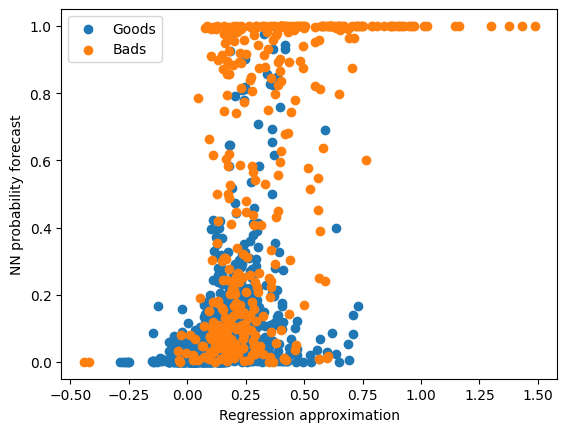

In [10]:
# Scatter plot of regression versus NN outputs, colored by actual target
plt.scatter(df_comp.LR[df_comp.Y==0], df_comp.NN[df_comp.Y==0], label="Goods")
plt.scatter(df_comp.LR[df_comp.Y==1], df_comp.NN[df_comp.Y==1], label="Bads")
plt.xlabel("Regression approximation")
plt.ylabel("NN probability forecast")
plt.legend(loc="best")
plt.show()

## Permutation-based feature importance
We introduces the concepts of permutation-based feature importance in the lecture. Now we want to examine how it works in Python. Of course, this will require us finding a Python method that implements the approach. To shortcut your searching, note that there is such method in *the most popular Python library for ML* and it is called `permutation_importance`. 

In [11]:
# Permutation-based feature importance
from sklearn.inspection import permutation_importance
feature_imp = permutation_importance(estimator=nn, X=Xtest, y=ytest)


The calculation of feature importance is pretty easy. However, visualizing the estimates importance scores takes a little work. Fortunately, this is a standard task and ready-to-use demo code is easily found on the web. In fact, we only found to browse the [official sklearn website](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py) and will find some nice demo code to plot feature importance scores as a boxplot.  

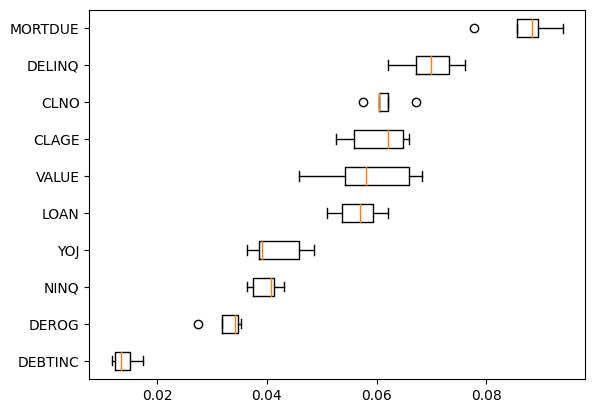

In [12]:
# Creating PDPs 
perm_sorted_idx = feature_imp.importances_mean.argsort()

plt.boxplot(
    feature_imp.importances[perm_sorted_idx].T, vert=False, labels=X.columns[perm_sorted_idx]
)

plt.show()

## Partial dependence
Next up, we discussed the concept of partial dependence. A partial dependence plot (PDP) complements feature importance analysis. For example, it is interesting to examine how those features that importance analysis identified as crucial affect model predictions (when averaging over the effect of the other features). Let's try to create a PDP for our NN-classifier. 

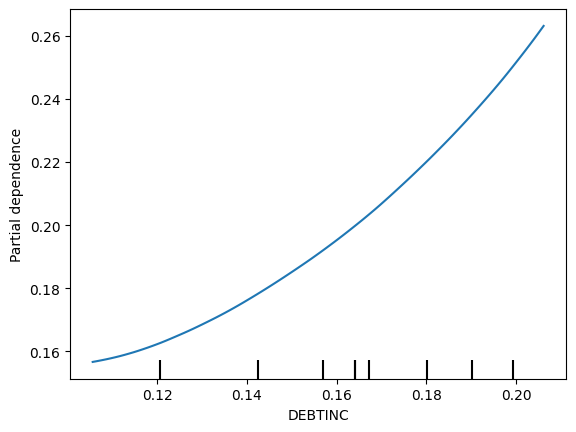

In [ ]:
# Partial dependence analysis
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(estimator=nn,X=Xtest, features=['MORTDUE'])
plt.show()